In [1]:
# this is joha's file, a Marie's  cousin file! ;)

In [ ]:

import pandas
import os
import numpy as np


df = pandas.read_csv("1335.vdb.tab", sep="\t", header =None) 
#Récupère la liste de nombre, correspondant aux comptage des différents espèces en fonction des lieu de prélevement
#2=door_in_1 ; 3=door_in_2 ; 4=faucet_handle_1 ; 5=faucet_handle_2 ; 6=sink_floor_1 ; 7=sink_floor_2
#8=soap_dispenser_1 ; 9=stall_in_1 ; 10=toilet_floor_1 ; 11=toilet_floor_1 ; 12=toilet_flush_handle_1
#13=toilet_flush_handle_2 ; 14=toilet_seat_1 ; 15=toilet_seat_2
def getcountsfromrow(row):
    l_l = [ int(row[2]),
            int(row[3]),
            int(row[4]),
            int(row[5]),
            int(row[6]),
            int(row[7]),
            int(row[8]),
            int(row[9]),
            int(row[10]),
            int(row[11]),
            int(row[12]),
            int(row[13]),
            int(row[14]),
            int(row[15]) ]
    return l_l

"""
Code pour generer dictionnaire. 

Au prealable, avec cat 1335.vdb.tab | cut -f 2 | cut -d ";" -f 1 | uniq
OTUConTaxonomy"Bacteria(100)  => on a confirmé que ce sont toutes Bacteria
"""
def getDicoTaxo(df):
    dicotaxo = { "name" : "Bacteria", "count" : [0 for i in range(14)], "children" : []}
    for index,row in df.iterrows():
        leveltax = row[1].split(';')  # uniquement indexes >=1 m'interessent 
        if index > 0:
            COUNTS = getcountsfromrow(row)
            tmp5 = {}
            tmp4 = {}
            tmp3 = {}
            tmp2 = {}
            tmp1 = {}
            tmp5["name"] = leveltax[5]
            tmp4["name"] = leveltax[4]
            tmp3["name"] = leveltax[3]
            tmp2["name"] = leveltax[2]
            tmp1["name"] = leveltax[1]      
            tmp5["count"] =  getcountsfromrow(row)
            tmp5["children"] = []  # lowest level
            tmp4["count"] =  getcountsfromrow(row)
            tmp4["children"] = [tmp5]
            tmp3["count"] =  getcountsfromrow(row)
            tmp3["children"] = [tmp4]
            tmp2["count"] =  getcountsfromrow(row)
            tmp2["children"] = [tmp3]
            tmp1["count"] = getcountsfromrow(row)
            tmp1["children"] = [tmp2]
            tmpcounts = dicotaxo["count"]
            dicotaxo["count"] = np.add(tmpcounts, COUNTS)
            if leveltax[1] not in [m["name"] for m in dicotaxo["children"]] :
                dicotaxo["children"].append(tmp1)
            else:
                for m in dicotaxo["children"]:
                    if m["name"] == leveltax[1]:
                        tmpc = m["count"]
                        m["count"] = np.add(tmpc, COUNTS)
                        if leveltax[2] not in [n["name"] for n in m["children"]] :
                            m["children"].append(tmp2)
                        else:
                            for n in m["children"]:
                                if n["name"] == leveltax[2]:
                                    tmpc = n["count"]
                                    n["count"] = np.add(tmpc, COUNTS)
                                    if leveltax[3] not in [o["name"] for o in n["children"]]:
                                        n["children"].append(tmp3)
                                    else: 
                                        for o in n["children"]:
                                            if o["name"] == leveltax[3]:
                                                tmpc = o["count"]
                                                o["count"] = np.add(tmpc,COUNTS)
                                                if leveltax[4] not in [p["name"] for p in o["children"]]:
                                                    o["children"].append(tmp4)
                                                else:
                                                    for p in o["children"]:
                                                        if p["name"] == leveltax[4]:
                                                            tmpc = p["count"]
                                                            p["count"] = np.add(tmpc, COUNTS)
                                                            if leveltax[5] not in [q["name"] for q in p["children"]]:
                                                                p["children"].append(tmp5)
                                                            else:
                                                                for q in p["children"]:
                                                                    if q["name"] == leveltax[5]:
                                                                        tmpc = q["count"]
                                                                        q["count"] = np.add(tmpc, COUNTS)
                                                                        q["children"] = []
                                                                        # this is the lowest level                                        
    return dicotaxo

dicoTaxoTest = getDicoTaxo(df)

In [2]:
"""
Veut pouvoir récuperer donnée intéressantes dans dictionnaire.
"""

def convertNiv(niveau):
    if niveau.upper() == "REGNE":
        return 1
    if niveau.upper() == "PHYLUM":
        return 2
    if niveau.upper() == "CLASSE":
        return 3
    if niveau.upper() == "ORDRE":
        return 4
    if niveau.upper() == "FAMILLE":
        return 5
    if niveau.upper() == "GENRE":
        return 6
    
def dicoListeNiveau(nomList, dico):
    dico[nomList] = []
    
#Méthode 1 : En fonction du niveaux de taxo récupéré donnne pour l'espèce le comptage en fonction du lieu
#Input : niveau taxo Regne;Phylum;Classe;Ordre;Famille;Genre
#Output : liste de vecteurs 1er : vecteur des espèces, 
#puis 1 vecteurs par localisation (1 vecteur donne le comptage pour l'espèce dans la localisation donnée)
def getNiv(niveau,dicoTaxo):
    niv = convertNiv(niveau)
    vecteurs = []
    dicoListeNivx = {}
    #Regne 
    listeRegne = []
    #Regne compte
    listelRegne = []
    #Autre niveau
    listePhylum =[]
    listeClasse =[]
    listeOrdre =[]
    listeFamille =[]
    listeGenre =[]
    #autre niveau compte
    for i in range(1,15):
        nomList = f"listel{i}" + niveau.lower()
        dicoListeNiveau(nomList,dicoListeNivx )

    for k1, v1 in dicoTaxo.items():
        #Récupère que pour le règne
        if k1 == "name" and niv == 1:
            listeRegne.append(v1)
            vecteurs.append(listeRegne)
        elif k1 == "count" and niv == 1:
            listelRegne.append(v1)
            vecteurs.append(listelRegne)
        elif k1 == "children" and niv > 1: 
            for phylum in dicoTaxo['children']:
                for k2, v2 in phylum.items():
                    #Récupère que pour le phylum
                    if k2 == "name" and niv == 2:
                        listePhylum.append(v2)
                    elif k2 == "count" and niv == 2:
                        for i in range(0,14):
                            numList = i+1
                            nomList = f"listel{numList}" + niveau.lower()
                            dicoListeNivx[nomList].append(v2[i])

                    #Descend dans les niveau plus précis
                    elif k2 == "children" and niv > 2:
                        for classe in v2:
                            for k3, v3 in classe.items():
                                #Récupère que pour la classe
                                if k3 == "name" and niv == 3:
                                    listeClasse.append(v3)
                                elif k3 == "count" and niv == 3:
                                     for i in range(0,14):
                                        numList = i+1
                                        nomList = f"listel{numList}" + niveau.lower()
                                        dicoListeNivx[nomList].append(v3[i])
                                #Descend dans les niveau plus précis
                                elif k3 == "children" and niv > 3:
                                    for ordre in v3:
                                        for k4, v4 in ordre.items():
                                            #Récupère que pour l'ordre
                                            if k4 == "name" and niv == 4:
                                                listeOrdre.append(v4)
                                            elif k4 == "count" and niv == 4:
                                                for i in range(0,14):
                                                    numList = i+1
                                                    nomList = f"listel{numList}" + niveau.lower()
                                                    dicoListeNivx[nomList].append(v4[i])
                                            #Descend dans les niveau plus précis
                                            elif k4 == "children" and niv > 4:
                                                for famille in v4:
                                                    for k5, v5 in famille.items():
                                                        #Récupère que pour la famille
                                                        if k5 == "name" and niv == 5:
                                                            listeFamille.append(v5)
                                                        elif k5 == "count" and niv == 5:
                                                            for i in range(0,14):
                                                                numList = i+1
                                                                nomList = f"listel{numList}" + niveau.lower()
                                                                dicoListeNivx[nomList].append(v5[i])
                                                        #Descend dans les niveau plus précis
                                                        elif k5 == "children" and niv > 5:
                                                            for genre in v5:
                                                                for k6, v6 in genre.items():
                                                                    #Récupère que pour la famille
                                                                    if k6 == "name" and niv == 6:
                                                                        listeGenre.append(v6)
                                                                    elif k6 == "count" and niv == 6:
                                                                        for i in range(0,14):
                                                                            numList = i+1
                                                                            nomList = f"listel{numList}" + niveau.lower()
                                                                            dicoListeNivx[nomList].append(v6[i])
                                                                    

    
    if niv == 2:
        vecteurs.append(listePhylum);vecteurs.append(dicoListeNivx['listel1phylum']);vecteurs.append(dicoListeNivx['listel2phylum']);vecteurs.append(dicoListeNivx['listel3phylum'])
        vecteurs.append(dicoListeNivx['listel4phylum']);vecteurs.append(dicoListeNivx['listel5phylum']);vecteurs.append(dicoListeNivx['listel6phylum']);vecteurs.append(dicoListeNivx['listel7phylum'])
        vecteurs.append(dicoListeNivx['listel8phylum']);vecteurs.append(dicoListeNivx['listel9phylum']);vecteurs.append(dicoListeNivx['listel10phylum']);vecteurs.append(dicoListeNivx['listel11phylum'])
        vecteurs.append(dicoListeNivx['listel12phylum']);vecteurs.append(dicoListeNivx['listel13phylum']);vecteurs.append(dicoListeNivx['listel14phylum']);
    if niv == 3:
        vecteurs.append(listeClasse);vecteurs.append(dicoListeNivx['listel1classe']);vecteurs.append(dicoListeNivx['listel2classe']);vecteurs.append(dicoListeNivx['listel3classe'])
        vecteurs.append(dicoListeNivx['listel4classe']);vecteurs.append(dicoListeNivx['listel5classe']);vecteurs.append(dicoListeNivx['listel6classe']);vecteurs.append(dicoListeNivx['listel7classe'])
        vecteurs.append(dicoListeNivx['listel8classe']);vecteurs.append(dicoListeNivx['listel9classe']);vecteurs.append(dicoListeNivx['listel10classe']);vecteurs.append(dicoListeNivx['listel11classe'])
        vecteurs.append(dicoListeNivx['listel12classe']);vecteurs.append(dicoListeNivx['listel13classe']);vecteurs.append(dicoListeNivx['listel14classe']);
    if niv == 4:
        vecteurs.append(listeOrdre);vecteurs.append(dicoListeNivx['listel1ordre']);vecteurs.append(dicoListeNivx['listel2ordre']);vecteurs.append(dicoListeNivx['listel3ordre'])
        vecteurs.append(dicoListeNivx['listel4ordre']);vecteurs.append(dicoListeNivx['listel5ordre']);vecteurs.append(dicoListeNivx['listel6ordre']);vecteurs.append(dicoListeNivx['listel7ordre'])
        vecteurs.append(dicoListeNivx['listel8ordre']);vecteurs.append(dicoListeNivx['listel9ordre']);vecteurs.append(dicoListeNivx['listel10ordre']);vecteurs.append(dicoListeNivx['listel11ordre'])
        vecteurs.append(dicoListeNivx['listel12ordre']);vecteurs.append(dicoListeNivx['listel13ordre']);vecteurs.append(dicoListeNivx['listel14ordre']);
    if niv == 5:
        vecteurs.append(listeFamille);vecteurs.append(dicoListeNivx['listel1famille']);vecteurs.append(dicoListeNivx['listel2famille']);vecteurs.append(dicoListeNivx['listel3famille'])
        vecteurs.append(dicoListeNivx['listel4famille']);vecteurs.append(dicoListeNivx['listel5famille']);vecteurs.append(dicoListeNivx['listel6famille']);vecteurs.append(dicoListeNivx['listel7famille'])
        vecteurs.append(dicoListeNivx['listel8famille']);vecteurs.append(dicoListeNivx['listel9famille']);vecteurs.append(dicoListeNivx['listel10famille']);vecteurs.append(dicoListeNivx['listel11famille'])
        vecteurs.append(dicoListeNivx['listel12famille']);vecteurs.append(dicoListeNivx['listel13famille']);vecteurs.append(dicoListeNivx['listel14famille']);
    if niv == 6:
        vecteurs.append(listeGenre);vecteurs.append(dicoListeNivx['listel1genre']);vecteurs.append(dicoListeNivx['listel2genre']);vecteurs.append(dicoListeNivx['listel2genre'])
        vecteurs.append(dicoListeNivx['listel4genre']);vecteurs.append(dicoListeNivx['listel5genre']);vecteurs.append(dicoListeNivx['listel6genre']);vecteurs.append(dicoListeNivx['listel7genre'])
        vecteurs.append(dicoListeNivx['listel8genre']);vecteurs.append(dicoListeNivx['listel9genre']);vecteurs.append(dicoListeNivx['listel10genre']);vecteurs.append(dicoListeNivx['listel11genre'])
        vecteurs.append(dicoListeNivx['listel12genre']);vecteurs.append(dicoListeNivx['listel13genre']);vecteurs.append(dicoListeNivx['listel14genre']);
    
    return vecteurs

In [3]:
#Création df
def getDF(dicoTaxo):
    listeDf=[]
    listeRegne=["regne"]
    for k1, v1 in dicoTaxo.items():
        #Récupère que pour le règne
        if k1 == "name":
            listeRegne.append(v1)
        elif k1 == "count" :
            for i in range(0,14):
                listeRegne.append(int(v1[i]))
            listeDf.append(listeRegne)
        elif k1 == "children":
            for phylum in dicoTaxo['children']:
                listePhylum = ["phylum"]
                for k2, v2 in phylum.items():
                    #Récupère que pour le phylum
                    if k2 == "name" :
                        listePhylum.append(v2)
                    elif k2 == "count" :
                        for i in range(0,14):
                            listePhylum.append(int(v2[i]))
                        listeDf.append(listePhylum)
                    #Descend dans les niveau plus précis
                    elif k2 == "children" :
                        for classe in v2:
                            listeClasse = ["classe"]
                            for k3, v3 in classe.items():
                                #Récupère que pour le phylum
                                if k3 == "name" :
                                    listeClasse.append(v3)
                                elif k3 == "count" :
                                    for i in range(0,14):
                                        listeClasse.append(int(v3[i]))
                                    listeDf.append(listeClasse)
                                #Descend dans les niveau plus précis
                                elif k2 == "children" :
                                    for ordre in v3:
                                        listeOrdre = ["ordre"]
                                        for k4, v4 in ordre.items():
                                            #Récupère que pour le phylum
                                            if k4 == "name" :
                                                listeOrdre.append(v4)
                                            elif k4 == "count" :
                                                for i in range(0,14):
                                                    listeOrdre.append(int(v4[i]))
                                                listeDf.append(listeOrdre)
                                            #Descend dans les niveau plus précis
                                            elif k4 == "children" :
                                                for famille in v4:
                                                    listeFamille = ["famille"]
                                                    for k5, v5 in famille.items():
                                                        #Récupère que pour le phylum
                                                        if k5 == "name" :
                                                            listeFamille.append(v5)
                                                        elif k5 == "count" :
                                                            for i in range(0,14):
                                                                listeFamille.append(int(v5[i]))
                                                            listeDf.append(listeFamille)
                                                         #Descend dans les niveau plus précis
                                                        elif k5 == "children" :
                                                            for genre in v5:
                                                                listeGenre = ["genre"]
                                                                for k6, v6 in genre.items():
                                                                    #Récupère que pour le phylum
                                                                    if k6 == "name" :
                                                                        listeGenre.append(v6)
                                                                    elif k6 == "count" :
                                                                        for i in range(0,14):
                                                                            listeGenre.append(int(v6[i]))
                                                                        listeDf.append(listeGenre)
                                                                    
    listelegColonne=["Nvx_taxo", "Taxo", "door_in_1","door_in_2", "faucet_handle_1", 
                "faucet_handle_2", "sink_floor_1", "sink_floor_2",
               "soap_dispenser_1", "stall_in_1", "toilet_floor_1", 
               "toilet_floor_2", "toilet_flush_handle_1",
               "toilet_flush_handle_2", "toilet_seat_1", "toilet_seat_2"]
    ar = np.array(listeDf)
    df = pandas.DataFrame(ar, columns = listelegColonne )
    return df

dicoTaxoTest = getDicoTaxo(df)
df2 = getDF(dicoTaxoTest)
df2



,Nvx_taxo,Taxo,door_in_1,door_in_2,faucet_handle_1,faucet_handle_2,sink_floor_1,sink_floor_2,soap_dispenser_1,stall_in_1,toilet_floor_1,toilet_floor_2,toilet_flush_handle_1,toilet_flush_handle_2,toilet_seat_1,toilet_seat_2
0,regne,Bacteria,3119,3119,3119,3119,3119,3119,3119,3119,3119,3119,3119,3119,3119,3119
1,phylum,Actinobacteria(100),1669,1483,434,2224,1382,978,1665,1057,1133,1013,1006,1400,685,1968
2,classe,Actinobacteria(100),1669,1483,434,2224,1379,974,1665,1053,1132,1009,996,1400,685,1968
3,ordre,Actinomycetales(100),1658,1482,431,2220,1358,948,1632,1047,1087,967,866,1390,680,1965
4,famille,Propionibacteriaceae(100),1398,1055,338,597,202,143,1159,630,151,171,63,355,83,212
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1010,phylum,Parcubacteria(100),0,0,0,0,0,0,0,0,0,1,4,0,0,0
1011,classe,unclassified(100),0,0,0,0,0,0,0,0,0,1,4,0,0,0
1012,ordre,unclassified(100),0,0,0,0,0,0,0,0,0,1,4,0,0,0
1013,famille,unclassified(100),0,0,0,0,0,0,0,0,0,1,4,0,0,0


In [4]:
def abondanceImportant(vecteurs):
    sum = 0
    lgVecteur = len(vecteurs[0])
    rangeb = len(vecteurs[0])-1
    listNumsup = []
    for i in range(0,rangeb):
        sum = vecteurs[1][i] +vecteurs[2][i]+vecteurs[3][i]+vecteurs[4][i]+vecteurs[5][i]+vecteurs[6][i]+vecteurs[7][i]+vecteurs[8][i]+vecteurs[9][i]+vecteurs[10][i]+vecteurs[11][i]+vecteurs[12][i]+vecteurs[13][i]+vecteurs[14][i]
        if sum < 250 :
            listNumsup.append(i)
    nbSup = 0
    for i in listNumsup:
        if(lgVecteur == len(vecteurs[0]) ):
            del vecteurs[0][i]
            del vecteurs[1][i]
            del vecteurs[2][i]
            del vecteurs[3][i]
            del vecteurs[4][i]
            del vecteurs[5][i]
            del vecteurs[6][i]
            del vecteurs[7][i]
            del vecteurs[8][i]
            del vecteurs[9][i]
            del vecteurs[10][i]
            del vecteurs[11][i]
            del vecteurs[12][i]
            del vecteurs[13][i]
            del vecteurs[14][i]
        else:
            nbSup = nbSup + 1
            i = i-nbSup
            del vecteurs[0][i]
            del vecteurs[1][i]
            del vecteurs[2][i]
            del vecteurs[3][i]
            del vecteurs[4][i]
            del vecteurs[5][i]
            del vecteurs[6][i]
            del vecteurs[7][i]
            del vecteurs[8][i]
            del vecteurs[9][i]
            del vecteurs[10][i]
            del vecteurs[11][i]
            del vecteurs[12][i]
            del vecteurs[13][i]
            del vecteurs[14][i]
        
    return vecteurs         

In [5]:
#Création matrice pour heat map
import numpy as np

def matrice(vecteurs):
    mat = np.array([vecteurs[1],vecteurs[2],vecteurs[3],vecteurs[4],vecteurs[5],vecteurs[6],vecteurs[7],vecteurs[8],vecteurs[9],
           vecteurs[10],vecteurs[11],vecteurs[12],vecteurs[13],vecteurs[14]])
    return mat


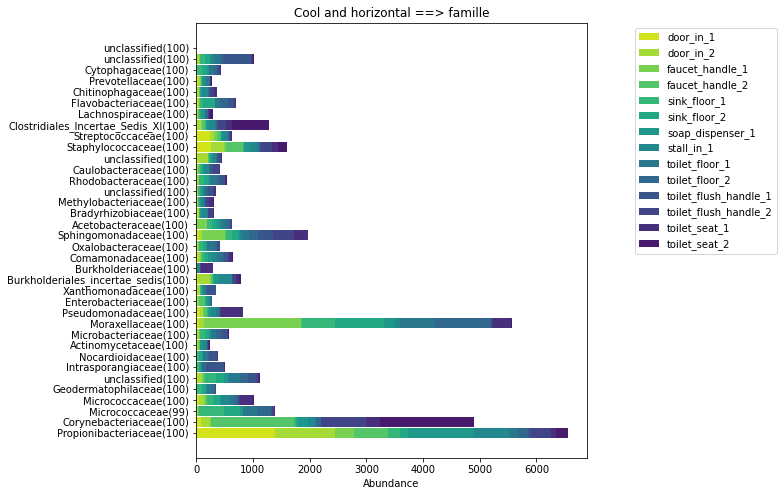

In [7]:
SELECTED = "famille" 
dicoTaxoTest = getDicoTaxo(df)
vecteurs = getNiv(SELECTED,dicoTaxoTest) 

localisation=["door_in_1","door_in_2", "faucet_handle_1", 
                "faucet_handle_2", "sink_floor_1", "sink_floor_2",
               "soap_dispenser_1", "stall_in_1", "toilet_floor_1", 
               "toilet_floor_2", "toilet_flush_handle_1",
               "toilet_flush_handle_2", "toilet_seat_1", "toilet_seat_2"]

vecteursTrier = abondanceImportant(vecteurs)
selected_niv=vecteursTrier[0]
N=len(selected_niv)
ind = np.arange(N)

l_loc = []
for i in range(len(localisation)):
    l_loc.append(vecteursTrier[i+1]) #car vecteursTrier[1] --> "door_in_1"
    

height = 0.9
fig = plt.figure(figsize=[7, 8])
bars = []
cols = sns.color_palette('viridis_r',14) #COLORS
#NOTE:max colors for "colorblind" are 10, look for solution soon!
cumulated = np.zeros(len(l_loc[0]),dtype=int)
for i in range(len(localisation)):
    if i == 0 :
        tmpbarobject = plt.barh(ind,l_loc[i], height,color=cols[i])
    else: 
        tmpbarobject = plt.barh(ind, l_loc[i],height, left=cumulated, color=cols[i]) 

    cumulated = np.add(l_loc[i],cumulated)
    bars.append(tmpbarobject[0])

plt.xlabel('Abundance') 
plt.title('Cool and horizontal ==> ' + SELECTED) 
plt.yticks(ind, (selected_niv)) 
# legende dehors du plot area avec: bbbox_to_anchor
plt.legend(bars, localisation, bbox_to_anchor=(1.5, 1)) 
  
plt.show()

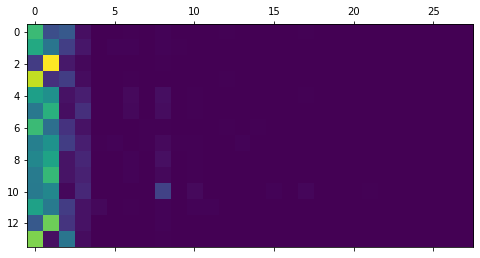

In [8]:
##Test heatmap
#idem peut être normalisation ? 
dicoTaxoTest = getDicoTaxo(df)
vecteurs = getNiv("Phylum",dicoTaxoTest)
mat = matrice(vecteurs)

plt.matshow(mat)

In [9]:
SELECTED = "ordre" 
dicoTaxoTest = getDicoTaxo(df)
vecteurs = getNiv(SELECTED,dicoTaxoTest) 

localisation=["door_in_1","door_in_2", "faucet_handle_1", 
                "faucet_handle_2", "sink_floor_1", "sink_floor_2",
               "soap_dispenser_1", "stall_in_1", "toilet_floor_1", 
               "toilet_floor_2", "toilet_flush_handle_1",
               "toilet_flush_handle_2", "toilet_seat_1", "toilet_seat_2"]

vecteursTrier = abondanceImportant(vecteurs)
selected_niv=vecteursTrier[0]
N=len(selected_niv)
ind = np.arange(N)

l_loc = []
for i in range(len(localisation)):
    l_loc.append(vecteursTrier[i+1]) #car vecteursTrier[1] --> "door_in_1"


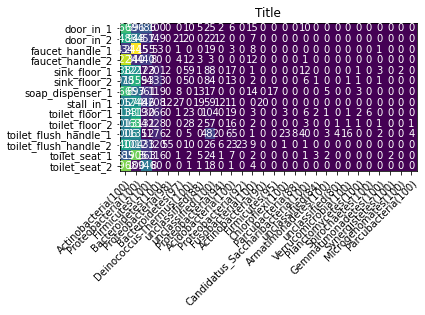

In [10]:
import matplotlib.pyplot as plt

##Test heatmap
dicoTaxoTest = getDicoTaxo(df)
vecteurs = getNiv("Phylum",dicoTaxoTest)
mat = matrice(vecteurs)

localisation = ["door_in_1","door_in_2", "faucet_handle_1", 
                "faucet_handle_2", "sink_floor_1", "sink_floor_2",
               "soap_dispenser_1", "stall_in_1", "toilet_floor_1", 
               "toilet_floor_2", "toilet_flush_handle_1",
               "toilet_flush_handle_2", "toilet_seat_1", "toilet_seat_2"]

espece=vecteurs[0]

fig, ax = plt.subplots()
im = ax.imshow(mat)

ax.set_xticks(np.arange(len(espece)))
ax.set_yticks(np.arange(len(localisation)))

ax.set_xticklabels(espece)
ax.set_yticklabels(localisation)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

for i in range(len(localisation)):
    for j in range(len(espece)):
        text = ax.text(j, i, mat[i, j],
                       ha="center", va="center", color="w")


ax.set_title("Title")
fig.tight_layout()
plt.show()        

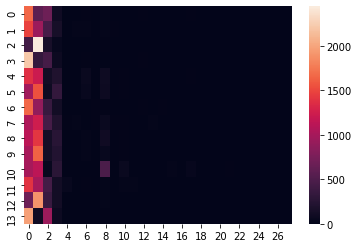

In [11]:
import seaborn as sns
##Test heatmap
dicoTaxoTest = getDicoTaxo(df)
vecteurs = getNiv("Phylum",dicoTaxoTest)
mat = matrice(vecteurs)
localisation = ["door_in_1","door_in_2", "faucet_handle_1", 
                "faucet_handle_2", "sink_floor_1", "sink_floor_2",
               "soap_dispenser_1", "stall_in_1", "toilet_floor_1", 
               "toilet_floor_2", "toilet_flush_handle_1",
               "toilet_flush_handle_2", "toilet_seat_1", "toilet_seat_2"]

espece=vecteurs[0]

ax = sns.heatmap(mat)

In [12]:
import matplotlib.pyplot as plt
import squarify


#test treemap avec df
dicoTaxoTest = getDicoTaxo(df)
df4 = getDF(dicoTaxoTest)

#fig, ax = plt.subplots(1, figsize = (12,12))
'''liste = []
taille = len(df4['door_in_1'])
for i in range(0,taille-1):
    if df4['door_in_1'][i] == 0:
        liste.append(1)
    else:
        liste.append(int(df4['door_in_1'][i]))'''
    
#squarify.plot(sizes=df4['door_in_1'], 
#              label=df4['Taxo'], 
#              alpha=.8 )
#plt.axis('off')
#plt.show()

"liste = []\ntaille = len(df4['door_in_1'])\nfor i in range(0,taille-1):\n    if df4['door_in_1'][i] == 0:\n        liste.append(1)\n    else:\n        liste.append(int(df4['door_in_1'][i]))"

In [13]:
#test treemap
import squarify
import matplotlib.cm as cm 
import matplotlib

dicoTaxoTest = getDicoTaxo(df)
vecteurs = getNiv("Phylum",dicoTaxoTest)
mat = matrice(vecteurs)

def getMax(mat):
    maxi = 0
    for ligne in mat:
        for i in ligne:
            if i > maxi:
                maxi = i
    return maxi

def getMin(mat, maxi):
    mini = 0
    for ligne in mat:
        for i in ligne:
            if i < mini:
                mini = i
    return mini


cmap = cm.Blues
maxi = getMax(mat)
mini = getMin(mat, maxi)
my_values=[i**3 for i in range(1,100)]
my_values

norm = matplotlib.colors.Normalize(vmin=mini, vmax=maxi)
colors = [cmap(norm(value)) for value in mat]
 
#Change color
#squarify.plot(sizes=mat, alpha=.8, color=colors )
#plt.axis('off')
#plt.show()

In [15]:
#PCA bad version
import matplotlib.pyplot as plt
#from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import pylab as pl
from sklearn.decomposition import PCA
from sklearn import preprocessing

vecteurs = getNiv("Genre",dicoTaxoTest)
mat = matrice(vecteurs)
localisation = ["door_in_1","door_in_2", "faucet_handle_1", 
                "faucet_handle_2", "sink_floor_1", "sink_floor_2",
               "soap_dispenser_1", "stall_in_1", "toilet_floor_1", 
               "toilet_floor_2", "toilet_flush_handle_1",
               "toilet_flush_handle_2", "toilet_seat_1", "toilet_seat_2"]
df = pandas.DataFrame(mat, columns=range(mat.shape[1]))

# normalization
from sklearn import preprocessing
import plotly.express as px

data_scaled = pandas.DataFrame(preprocessing.scale(df),columns = df.columns) 

# PCA, see: http://www.python-simple.com/python-scikit-learn/scikit-pca.php
pca = PCA(n_components=3)
components = pca.fit_transform(data_scaled)

# components relations with features:
#pd.DataFrame(pca.components_,columns=data_scaled.columns,index = ['PC-1','PC-2'])

#plt.scatter(pcadf[:,0],pcadf[:,1])
fig = px.scatter(components, x=0,y=1,color=localisation)   
fig.show()
LEEEEEROOOOO

In [ ]:
## recuperation phylum by Marie:
#Recupère les donnéer et format en Df
dicoTaxoTest = getDicoTaxo(df)
dfEntier= getDF(dicoTaxoTest)

#Création DF avec seulement les comptage pour le phylum (dfComptage)
dfComptage = getDFFonctionTaxo(dfEntier, "phylum")
listeColonneSuprimer = ["Nvx_taxo","Taxo"]
getDFLoc(dfComptage,listeColonneSuprimer )

#Creéation DF avec seulement les noms des phylum (dfTaxo)
dfTaxo = getDFFonctionTaxo(dfEntier, "phylum")
listeColonneSuprimerPourTaxo = ["Nvx_taxo","door_in_1","door_in_2", "faucet_handle_1", "faucet_handle_2", "sink_floor_1", "sink_floor_2",
               "soap_dispenser_1", "stall_in_1", "toilet_floor_1", "toilet_floor_2", "toilet_flush_handle_1","toilet_flush_handle_2", "toilet_seat_1", "toilet_seat_2"]
getDFLoc(dfTaxo,listeColonneSuprimerPourTaxo )

dfComptage
dfTaxo

In [ ]:
### EXEMPLES ACP !!!!!!!!!!!!!!!!!!!!!!!!!!

In [ ]:
#####
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

iris = datasets.load_iris()
X = iris.data
y = iris.target

#In general it is a good idea to scale the data
scaler = StandardScaler()
scaler.fit(X)
X=scaler.transform(X)

pca = PCA()
pca.fit(X,y)
x_new = pca.transform(X)   

def myplot(score,coeff,labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]

    plt.scatter(xs ,ys, c = y) #without scaling
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'g', ha = 'center', va = 'center')
        else:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')

plt.xlabel("PC{}".format(1))
plt.ylabel("PC{}".format(2))
plt.grid()

#Call the function. 
myplot(x_new[:,0:2], pca.components_.T) 
plt.show()

In [ ]:
import numpy as np 
import pandas as pd
#import altair as alt
from numpy import linalg as LA
from sklearn import datasets
from sklearn.decomposition import PCA

# Téléchargement du jeux de données iris 

data, species = datasets.load_iris(return_X_y=True)

data = pd.DataFrame(data)
species = pd.DataFrame(species)

# Calcul de la matrice de covariance 
cov_matrix = data.cov()

# Calcul des vecteurs et valeurs propres de la matrice de covariance 
eigen_values, eigen_vectors = LA.eig(cov_matrix)

# Calcul de l'information récupéré en pourcentage sur les 2 premiers axes
info = (eigen_values / sum(eigen_values) * 100).round(2)
axe1_info = info[0]
axe2_info = info[1]

# Projection des points sur les deux premiers vecteurs 
projection_matrix = eigen_vectors.T[:][:2].T
data_t = data.dot(projection_matrix)

# Affichage des nouvelles données à 2 dimensions
data_t.columns = ["axe1", "axe2"]
data_t["species"] = species
